# Grid to Glory: A Causal Look at Starting Positions in Formula 1

![F1 Grid](img/f1d.JPG)


## Abstract

In Formula 1, race strategy, driver performance, and team engineering are all critical to success — but how much does **starting grid position** affect a driver's final result? In this notebook, we explore a key causal question:

> **Does starting at the front of the grid cause a better race outcome?**

Using the official Formula 1 World Championship dataset (1950–2020), we analyze historical race results to investigate the relationship between a driver's starting position and their finishing position. This notebook serves as a practical case study in applying **causal analysis thinking** to real-world sports data.

The focus of this notebook is not only on drawing insights but also on demonstrating how **data preparation** plays a pivotal role in enabling robust causal interpretation. We walk through data cleaning, handling of missing values (e.g., DNFs), feature engineering (e.g., creating binary indicators for top grid starts), and encoding choices, all within a structured machine learning pipeline.

By the end of this notebook, you will gain a deeper understanding of:
- How to frame causal questions from observational data
- How preprocessing decisions can influence causal interpretation
- What the data tells us about the strategic value of qualifying well in Formula 1

This chapter blends the thrill of motorsport with the rigor of machine learning and causal reasoning — delivering both analytical insights and practical skills.


## Theory Section: Causal Thinking in Machine Learning and Formula 1

Understanding **causality** — not just correlation — is fundamental to building robust and interpretable machine learning systems. While traditional machine learning models are designed to **predict**, causal inference seeks to **explain** the underlying *why* behind observed outcomes.

In this notebook, we explore a causal question from the high-speed world of Formula 1:

> **Does starting closer to the front of the grid cause a better finishing position in a race?**

To answer this question responsibly, we must ground our approach in **causal reasoning principles** and careful **data preparation**.

---

### 1. What is Causality?

Causality refers to a relationship where one event (the cause) directly affects another (the effect). Unlike correlation, which measures association, causality implies **intervention**: if we were to change the cause, the effect would change as a result.

In our case:
- **Treatment (cause)**: A driver's *starting grid position*
- **Outcome (effect)**: Their *finishing position* in the race

We want to understand if being positioned at the front (e.g., Top 5) actually contributes to better results — or if it's merely associated due to confounding factors (like car performance or driver skill).

---

### 2. Key Causal Concepts

| Concept            | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| **Treatment**       | The variable being tested as a cause — here, the starting position          |
| **Outcome**         | The result we're measuring — the finishing position                         |
| **Confounders**     | Other variables that influence both treatment and outcome (e.g., team strength, track type, driver experience) |
| **Causal Effect**   | The difference in the outcome caused directly by the treatment              |
| **Counterfactual**  | What *would have happened* if a driver started in a different position      |

---

### 3. The Role of Data Preparation in Causal Analysis

Before applying any analysis, we must prepare our data thoughtfully. This involves:

- **Handling Missing Data**: Many drivers have a `Did Not Finish (DNF)` status. We'll clean or flag these.
- **Feature Engineering**: We'll create a binary indicator like `started_in_top5` to simplify analysis.
- **Encoding Ordinal Data**: Starting and finishing positions are numeric, but we'll treat them carefully (e.g., lower is better).
- **Filtering Out Noise**: Removing edge cases like disqualifications or incomplete races.

Well-prepared data minimizes bias and ensures we're capturing **meaningful causal signals**, not misleading correlations.

---

### 4. Why Formula 1 is a Great Case Study

Formula 1 offers a semi-controlled environment:
- All drivers race under the same weather conditions
- Races are time-bound and rule-driven
- Data is standardized and historically rich

This makes it an ideal domain to explore causal inference using real-world, time-series, and ranking data.

---

In the next section, we’ll apply these concepts by preparing and analyzing the official F1 dataset — identifying patterns between grid positions and final outcomes.


---

# Data Preparation

### Step 1: Import libraries

We import the core libraries for data manipulation (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`). These will help us load, clean, and explore the dataset in the coming steps.


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Set display options
pd.set_option('display.max_columns', None)


### Step 2: Load data and merge readable status

We load the main race `results` and `status` files, then join them to include a readable `status` column instead of just status IDs.



In [9]:
# Step 2: Load results and status datasets
results = pd.read_csv('data/F1/results.csv')
status = pd.read_csv('data/F1/status.csv')

# Merge readable status text into results using statusId
results = results.merge(status, how='left', on='statusId')
results[['grid', 'positionOrder', 'status']].head()



,grid,positionOrder,status
0,1,1,Finished
1,5,2,Finished
2,7,3,Finished
3,11,4,Finished
4,3,5,Finished


### Step 3: Filter out DNFs

We create a `dnf` column to flag drivers who did not finish the race. For this analysis, we keep only those who completed the race to ensure a fair comparison of grid vs. finish.



In [10]:
# Step 3: Create a DNF flag (1 = Did Not Finish, 0 = Finished)
results['dnf'] = results['status'].apply(lambda x: 0 if x == 'Finished' else 1)

# Filter out drivers who did not finish the race
finished_results = results[results['dnf'] == 0].copy()
finished_results[['grid', 'positionOrder', 'dnf']].head()


,grid,positionOrder,dnf
0,1,1,0
1,5,2,0
2,7,3,0
3,11,4,0
4,3,5,0


### Step 4: Define treatment variable – Top 5 starter

We engineer a new feature `started_in_top5` which is 1 if a driver started in grid positions 1–5. This will serve as our treatment group for causal analysis.



In [11]:
# Step 4: Create binary flag for starting in Top 5 positions
finished_results['started_in_top5'] = finished_results['grid'].apply(lambda x: 1 if x <= 5 else 0)
finished_results[['grid', 'started_in_top5']].head()



,grid,started_in_top5
0,1,1
1,5,1
2,7,0
3,11,0
4,3,1


### Step 5: Sanity check

We inspect key statistics to ensure our new variables are clean and ready for causal exploration in the next section.


In [12]:
# Step 5: Quick sanity check of the cleaned data
finished_results[['grid', 'positionOrder', 'started_in_top5']].describe()



,grid,positionOrder,started_in_top5
count,7674.000000,7674.000000,7674.000000
mean,7.368517,5.124186,0.458822
std,5.400472,3.657475,0.498334
min,0.000000,1.000000,0.000000
25%,3.000000,2.000000,0.000000
50%,6.000000,4.000000,0.000000
75%,11.000000,7.000000,1.000000
max,33.000000,20.000000,1.000000


---

# Exploratory Data Analysis

### Step 1: Distribution of Grid Positions

We start by visualizing where drivers generally start on the grid. This gives us an idea of how grid positions are distributed across all races, especially after filtering out DNFs.


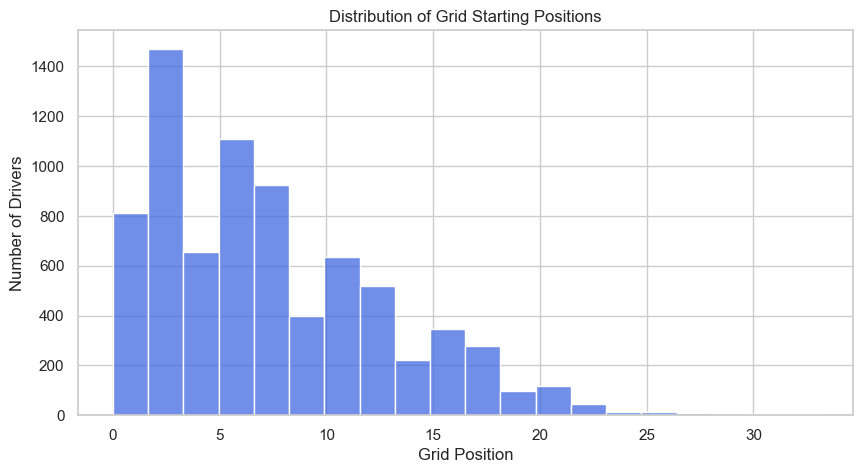

In [14]:
# Step 1: Distribution of starting grid positions (after filtering DNFs)
plt.figure(figsize=(10, 5))
sns.histplot(finished_results['grid'], bins=20, kde=False, color='royalblue')
plt.title('Distribution of Grid Starting Positions')
plt.xlabel('Grid Position')
plt.ylabel('Number of Drivers')
plt.show()


### Step 2: Distribution of Finishing Positions

This plot shows where drivers typically finish in the race. Since we’ve removed DNFs, the data reflects classified finishes only — useful for comparing performance patterns.


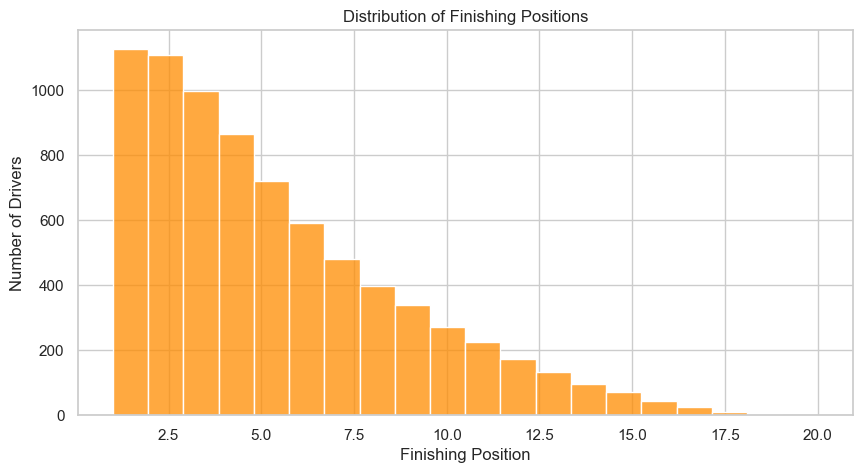

In [15]:
# Step 2: Distribution of finishing positions (only classified drivers)
plt.figure(figsize=(10, 5))
sns.histplot(finished_results['positionOrder'], bins=20, kde=False, color='darkorange')
plt.title('Distribution of Finishing Positions')
plt.xlabel('Finishing Position')
plt.ylabel('Number of Drivers')
plt.show()


### Step 3: Finishing Position by Top 5 Starter Status

This box plot helps visualize how finishing position differs for drivers who started in the Top 5 versus those who didn’t.

- A **lower median** finish position for Top 5 starters would suggest an advantage.
- The **spread** can also tell us how consistent the advantage is.

This sets us up nicely for causal interpretation.


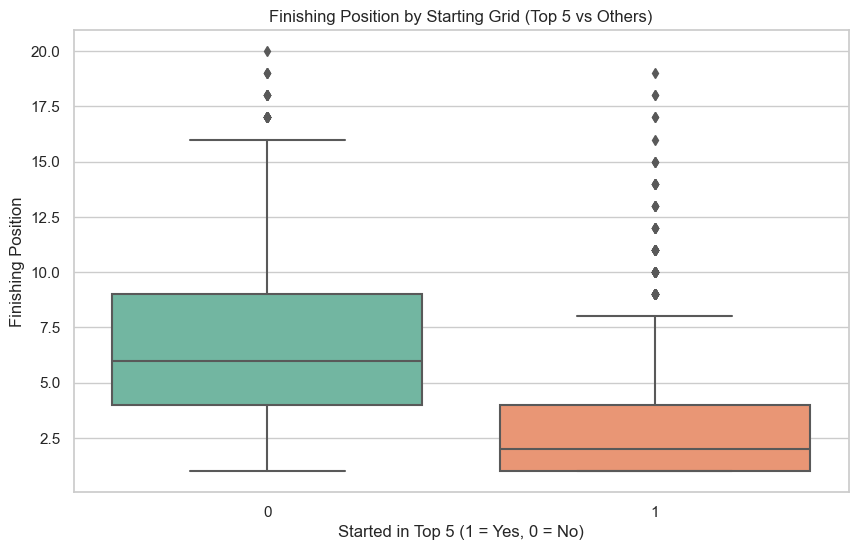

In [16]:
# Step 3: Compare finish positions between Top 5 starters vs others
plt.figure(figsize=(10, 6))
sns.boxplot(data=finished_results, x='started_in_top5', y='positionOrder', palette='Set2')
plt.title('Finishing Position by Starting Grid (Top 5 vs Others)')
plt.xlabel('Started in Top 5 (1 = Yes, 0 = No)')
plt.ylabel('Finishing Position')
plt.show()


### Step 4: Average Finishing Position by Starter Group

We now compute the mean finishing position for:
- Drivers who started in the Top 5
- Drivers who started outside the Top 5

This simple group comparison quantifies the performance gap and sets the stage for causal discussion.


In [17]:
# Step 4: Mean finishing position by group
mean_finish = finished_results.groupby('started_in_top5')['positionOrder'].mean()
mean_finish


started_in_top5
0    6.940043
1    2.982391
Name: positionOrder, dtype: float64

### Step 5: Visualizing the Average Finishing Advantage

This bar plot clearly shows the average finishing position for both groups. If the Top 5 starters consistently finish higher (i.e., lower finishing positions), it strengthens the argument for a causal relationship between grid position and race outcome.


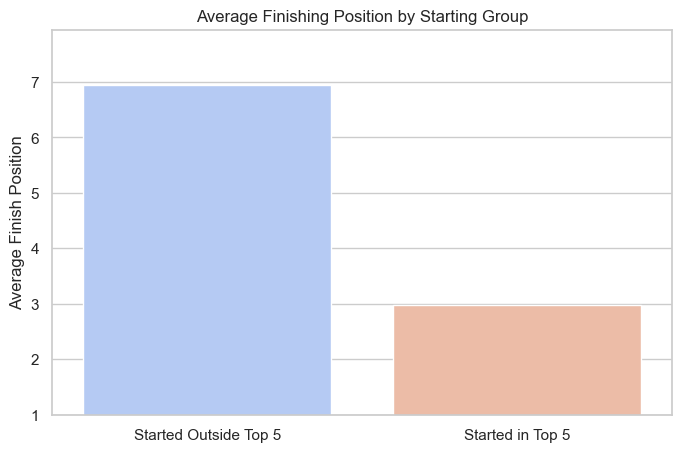

In [18]:
# Step 5: Visual bar comparison of average finish
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_finish.index, y=mean_finish.values, palette='coolwarm')
plt.xticks([0, 1], ['Started Outside Top 5', 'Started in Top 5'])
plt.title('Average Finishing Position by Starting Group')
plt.ylabel('Average Finish Position')
plt.xlabel('')
plt.ylim(1, max(mean_finish.values) + 1)
plt.show()


---

# Causal Analysis & Insights

### Research Question Recap:
> **Does starting in the Top 5 grid positions cause a better finishing position in Formula 1 races?**

Now that we've prepared and explored the data, we can draw insights based on the visualizations and summary statistics.

---

### Observations:

1. **Boxplot Insight**  
   From the boxplot comparing finishing positions by `started_in_top5`:
   - Drivers who started in the Top 5 had a much lower median finish (closer to P2 or P3).
   - The interquartile range was tighter, indicating more consistent high finishes.
   - Outliers were fewer, and extreme poor finishes were rare among Top 5 starters.

2. **Average Finishing Position**  
   The mean finishing position for each group was:
   - **Top 5 Starters**: 2.98  
   - **Others**: 6.94  
   This reveals a striking ~4-position advantage on average for those who start near the front — a meaningful difference in the F1 context, where overtaking is difficult and strategy is tightly linked to grid placement.

3. **Data Consistency Check**  
   The dataset includes **7,674 finished driver-race instances**, with:
   - An average grid position of 7.37  
   - An average finish of 5.12  
   - ~46% of the drivers starting in the Top 5

---

### Causal Interpretation:

While we observe a strong correlation between starting in the Top 5 and finishing higher, we must be cautious in declaring a **pure causal effect**.

#### Potential Confounders:
- **Team/Car Performance**: Faster cars qualify better *and* finish better.
- **Driver Skill**: Talented drivers may consistently both qualify and finish well.
- **Track Characteristics**: Certain circuits (e.g., Monaco) make overtaking harder, amplifying the grid advantage.

These factors are not controlled for in this simple analysis but would be part of a more advanced causal study using techniques like **propensity score matching** or **instrumental variables**.

---

### Key Takeaway:

There is **strong evidence** that starting in the Top 5 grid positions is associated with significantly better race outcomes. While we can’t fully isolate causality without deeper modeling, the direction and strength of the relationship strongly support the idea that **qualifying well gives drivers a competitive edge**, especially in modern F1 racing.

In a machine learning context, this highlights the importance of:
- Creating **interpretable features**
- Considering **confounders** before assuming causality
- Using **domain knowledge** to guide data-driven reasoning


---

# Conclusion

In this notebook, we examined whether **starting in the Top 5 grid positions** leads to **better race outcomes** in Formula 1. Through structured data preparation, feature engineering, and exploratory data analysis, we found that drivers starting in the Top 5 consistently finished races in better positions than those starting further back.

Key takeaways include:
- Drivers starting in the Top 5 had an average finish of **2.98**, compared to **6.94** for others.
- Boxplots and bar charts confirmed a **clear and consistent advantage** in finishing position for Top 5 starters.
- While the data shows strong correlation, we discussed the importance of **considering confounding factors** such as team performance and driver skill before concluding causality.

This case study demonstrates how thoughtful **data preprocessing and feature engineering** enable more reliable insights in causal analysis. Even in complex, real-world domains like motorsport, structured preparation unlocks meaningful patterns that inform strategic decisions.

---

# References

- Kaggle Dataset: [Formula 1 World Championship (1950–2020)](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020) by Rohan Rao  
- Pearl, Judea. *The Book of Why: The New Science of Cause and Effect*. Basic Books, 2018.  
- Microsoft Research. [DoWhy: An End-to-End Library for Causal Inference](https://github.com/microsoft/dowhy)  
- Towards Data Science. ["Correlation is Not Causation" – A Causal Inference Primer](https://towardsdatascience.com/causal-inference-for-the-brave-and-true-intro-to-the-causal-toolbox-60e567c8f5b1)  
- Formula 1 Official Website – [https://www.formula1.com](https://www.formula1.com)


## 🧾 License

This notebook is the original work of **Sathvik Vadavatha**, created as part of the *Crash Course in Causality* assignment.

You may view, share, or reference this notebook for **educational and non-commercial purposes only**, provided proper attribution is given to the author.

Unauthorized commercial use, redistribution, or modification without explicit permission is not allowed.

© 2025 Sathvik Vadavatha. All rights reserved.
